In [ ]:
#Initialisation
import os
os.environ["JAX_PLATFORMS"] = "cpu"  # Disable GPU for JAX (Remove if you want to use GPU)

import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm, trange

# deteministic random numbers
np.random.seed(0)
random.seed(0)

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling, Sampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize

from LINKS.Optimization import DifferentiableTools, Tools

#load the curves to fit
target_curves = np.load('target_curves.npy')

PROBLEM_TOOLS = Tools( # we have to define this outside the class due to pymoo deepcopy limitations
            device='cpu' # device to run the optimization on
        )  
PROBLEM_TOOLS.compile() # compile the functions for faster runs

class mechanism_synthesis_optimization(ElementwiseProblem):

    # When intializing, set the mechanism size and target curve
    def __init__(self, target_curve, N = 5):
        self.N = N
        variables = dict()

        # The upper triangular portion of our NxN Connectivity Matrix consists of Nx(N-1)/2 boolean variables:
        for i in range(N):
            for j in range(i):
                variables["C" + str(j) + "_" + str(i)] = Binary()

        # We Delete C0_1 since we know node 1 is connected to the motor
        del variables["C0_1"]

        #Our position matrix consists of Nx2 real numbers (cartesian coordinate values) between 0 and 1
        for i in range(2*N):
            variables["X0" + str(i)] = Real(bounds=(0.0, 1.0))

        # Our node type vector consists of N boolean variables (fixed vs non-fixed)
        for i in range(N):
            variables["fixed_nodes" + str(i)] =  Binary(N)

        # Our target node is an integer between 1 and N-1, (any except the motor node).
        variables["target"] = Integer(bounds=(1,N-1))

        # Set up some variables in the problem class we inherit for pymoo
        # n_obj=number of objectives, n_constr=number of constraints
        # Our objectives are chamfer distance and material, and they both have constraints.
        super().__init__(vars=variables, n_obj=2, n_constr=2)

        # Store the target curve point cloud
        self.target_curve = target_curve


    def convert_1D_to_mech(self, x):
        N = self.N

        # Get target joints index
        target_idx = x["target"]

        # Build connectivity matrix from its flattened constitutive variables
        C = np.zeros((N,N))
        x["C0_1"] = 1

        for i in range(N):
            for j in range(i):
                # C[i,j] = x["C" + str(j) + "_" + str(i)]
                C[j,i] = x["C" + str(j) + "_" + str(i)]

        edges = np.array(np.where(C==1)).T
        
        # Reshape flattened position matrix to its proper Nx2 shape
        x0 = np.array([x["X0" + str(i)] for i in range(2*N)]).reshape([N,2])

        # Extract a list of Nodes that are fixed from boolean fixed_nodes vector
        fixed_joints = np.where(np.array([x["fixed_nodes" + str(i)] for i in range(N)]))[0].astype(int)

        #We fix the motor and original ground node as 0 and 1 respectively in this implementation
        motor=np.array([0,1])

        return x0, edges, fixed_joints, motor, target_idx

    def convert_mech_to_1D(self, x0, edges, fixed_joints, target_idx=None, **kwargs):
        # This function assumes motor to be [0, 1] our random mechanism generator automatically does this
        N = self.N

        # Initialize dictionary to store 1D representation of mechanism
        x = {}

        # Store target node value
        if target_idx is None:
            target_idx = x0.shape[0]-1 # Assume last node is the target if not specified
            
        x["target"] = target_idx

        # Store connectivity matrix in its flattened form
        C = np.zeros((N,N), dtype=bool)
        C[edges[:,0], edges[:,1]] = 1
        C[edges[:,1], edges[:,0]] = 1
       
        for i in range(N):
            for j in range(i):
                x["C" + str(j) + "_" + str(i)] = C[i,j]

        del x["C0_1"]
        
        # Store position matrix in its flattened form
        if x0.shape[0] != N:
            x0 = np.pad(x0, ((0, N - x0.shape[0]), (0, 0)), 'constant', constant_values=0)
            
        for i in range(2*N):
            x["X0" + str(i)] = x0.flatten()[i]

        # Store fixed nodes in boolean vector form
        for i in range(N):
            x["fixed_nodes" + str(i)] = (i in fixed_joints) or (i>=N)

        return x

    def _evaluate(self, x, out, *args, **kwargs):
        #Convert to mechanism representation
        x0, edges, fixed_joints, motor, target_idx = self.convert_1D_to_mech(x)
        
        # Simulate
        distance, material = PROBLEM_TOOLS(x0,
                                edges,
                                fixed_joints,
                                motor,
                                self.target_curve,
                                target_idx=target_idx
                            )

        out["F"] = np.array([distance, material])
        out["G"] = out["F"] - np.array([0.75, 10.0])  # Constraints: distance <= 0.75, material <= 10.0

from LINKS.Optimization import MechanismRandomizer
from LINKS.Visualization import MechanismVisualizer

from LINKS.Visualization import GAVisualizer
from LINKS.Kinematics import MechanismSolver
from LINKS.Geometry import CurveEngine

from pymoo.indicators.hv import HV
ga_visualizer = GAVisualizer()
solver = MechanismSolver(device='cpu')
curve_engine = CurveEngine(device='cpu')

In [ ]:
# Genetic Algorithm Optimisation
# from pymoo.algorithms.moo.rnsga2 import RNSGA2

''' INIT '''
from utils.mechanism_io import load_mechanisms, save_mechanisms

''' INIT End '''


''' Setup '''
NUM_OF_NODES = 7
NUM_OF_MECH = 100
NUM_INIT_MECH = NUM_OF_MECH*100
NUM_OF_GENERATIONS = 581

ONLY_FIRST_CURVE = False
if ONLY_FIRST_CURVE:
        curves = [0]
else:
        curves = range(target_curves.shape[0])

TAKE_RANDOM = True
if TAKE_RANDOM:
    file_name= f'Random_nodes_{NUM_OF_NODES}_mech_{NUM_OF_MECH}_of_{NUM_INIT_MECH}'
''' Setup End '''

results = []
for curve_index in curves:
        mechanisms = load_mechanisms(f'{file_name}_curve_{curve_index}.npy')
        print("Input file:", f'{file_name}_curve_{curve_index}.npy', "numer of mechanisms:", len(mechanisms))

        problem = mechanism_synthesis_optimization(target_curves[curve_index], N=NUM_OF_NODES)

        initial_population = [problem.convert_mech_to_1D(**mech) for mech in mechanisms]

        class sample_from_random(Sampling):
                def _do(self, problem, n_samples, **kwargs):
                        return np.array([initial_population[i%len(initial_population)] for i in range(n_samples)])

        F = problem.evaluate(np.array(initial_population))[0]
        print(f'Best Distance Performance In random population: {F[:,0].min()}')
        print(f'Best Material Performance In random population: {F[:,1].min()}')

        algorithm = NSGA2(pop_size=len(initial_population),
                        sampling=sample_from_random(),
                        mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                        mutation=PolynomialMutation(prob=0.5),
                        eliminate_duplicates=MixedVariableDuplicateElimination())

        results.append(minimize(problem,
                        algorithm,
                        ('n_gen', NUM_OF_GENERATIONS),
                        verbose=True,
                        save_history=True,
                        seed=123
                        ))
        
        # algorithm = RNSGA2(
        #         pop_size=100,
        #         ref_points=np.atleast_2d(ref_point),
        #         sampling=sample_from_random(),
        #         mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
        #         mutation=PolynomialMutation(prob=0.5),
        #         eliminate_duplicates=MixedVariableDuplicateElimination()
        #         )
                
        #         results = minimize(
        #         problem,
        #         algorithm,
        #         ('n_gen', 100),
        #         verbose=True,
        #         save_history=True,
        #         seed=123
        # )

        if not results[curve_index].X is None:
                #Specify reference point
                ref_point = np.array([0.75, 10.0])

                #Calculate Hypervolume
                ind = HV(ref_point)
                hypervolume = ind(results[curve_index].F)

                #Print and plot
                print('Hyper Volume ~ %f' %(hypervolume))
                ga_visualizer.plot_HV(results[curve_index].F, ref_point, objective_labels=['Distance', 'Material']) #use the plot_HV function from utils
        else:
                print('Did Not Find Solutions!!')


# Write results from GA to file
for curve_index in curves:
    # add out population to submission
    mechanisms = []
    if not results[curve_index].X is None:
        for j in range(results[curve_index].X.shape[0]):
            if not isinstance(results[curve_index].X, dict):
                x0_member, edges, fixed_joints, motor, target_idx  = problem.convert_1D_to_mech(results[curve_index].X[j])
            else:
                x0_member, edges, fixed_joints, motor, target_idx  = problem.convert_1D_to_mech(results[curve_index].X)
            
            mech = {
                'x0': x0_member,
                'edges': edges,
                'fixed_joints': fixed_joints,
                'motor': motor,
                #'target_joint': target_idx # ignore for now
            }
            mechanisms.append(mech)
    file_name_temp = f'GA_nodes_{NUM_OF_NODES}_mech_{NUM_OF_MECH}_NUM_OF_GENERATIONS_{NUM_OF_GENERATIONS}'
    save_mechanisms(mechanisms, f'{file_name_temp}_curve_{curve_index}.npy', overwrite=True)
    print(file_name)
file_name = file_name_temp
print(len(mechanisms))


In [ ]:
# Plot the history of the genetic algorithm optimisation for each curve
for curve_index, result in enumerate(results):
    if hasattr(result, 'history') and result.history is not None:
        # Extract objective values from history
        F_hist = [e.opt.get("F") for e in result.history if e.opt is not None]
        F_hist = [F for F in F_hist if F is not None]
        if len(F_hist) == 0:
            print(f"No history found for curve {curve_index}")
            continue
        # For multi-objective, plot min of each objective over generations
        F_hist = np.array([F.min(axis=0) if F.ndim > 1 else F for F in F_hist])
        plt.figure(figsize=(8, 4))
        plt.plot(F_hist[:, 0], label='Best Distance')
        plt.plot(F_hist[:, 1], label='Best Material')
        plt.title(f'GA Optimisation History - Curve {curve_index}')
        plt.xlabel('Generation')
        plt.ylabel('Objective Value')
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print(f"No history attribute for result {curve_index}")

In [ ]:
# Plot the history of the genetic algorithm optimisation for all curves on one plot
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10.colors  # Up to 10 distinct colors

for curve_index, result in enumerate(results):
    if hasattr(result, 'history') and result.history is not None:
        # Extract objective values from history
        F_hist = [e.opt.get("F") for e in result.history if e.opt is not None]
        F_hist = [F for F in F_hist if F is not None]
        if len(F_hist) == 0:
            print(f"No history found for curve {curve_index}")
            continue
        # For multi-objective, plot min of each objective over generations
        F_hist = np.array([F.min(axis=0) if F.ndim > 1 else F for F in F_hist])
        plt.plot(F_hist[:, 0], label=f'Curve {curve_index}', color=colors[curve_index % len(colors)])
    else:
        print(f"No history attribute for result {curve_index}")

plt.axvline(x=271, color='red', linestyle='--', label='Generation 271')
plt.title('GA Optimisation History - Best Distance per Generation')
plt.xlabel('Generation')
plt.ylabel('Best Distance')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10.colors  # Up to 10 distinct colors

for curve_index, result in enumerate(results):
    if hasattr(result, 'history') and result.history is not None:
        # Extract objective values from history
        F_hist = [e.opt.get("F") for e in result.history if e.opt is not None]
        F_hist = [F for F in F_hist if F is not None]
        if len(F_hist) == 0:
            print(f"No history found for curve {curve_index}")
            continue
        # For multi-objective, plot average of each objective over generations
        F_hist = np.array([F.mean(axis=0) if F.ndim > 1 else F for F in F_hist])
        plt.plot(F_hist[:, 0], label=f'Curve {curve_index}', color=colors[curve_index % len(colors)])
    else:
        print(f"No history attribute for result {curve_index}")

plt.axvline(x=271, color='red', linestyle='--', label='Generation 271')
plt.title('GA Optimisation History - Average Distance per Generation')
plt.xlabel('Generation')
plt.ylabel('Average Objective Value')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10.colors  # Up to 10 distinct colors

for curve_index, result in enumerate(results):
    if hasattr(result, 'history') and result.history is not None:
        # Extract objective values from history
        F_hist = [e.opt.get("F") for e in result.history if e.opt is not None]
        F_hist = [F for F in F_hist if F is not None]
        if len(F_hist) == 0:
            print(f"No history found for curve {curve_index}")
            continue
        # For multi-objective, plot min of material (index 1) over generations
        F_hist = np.array([F.min(axis=0) if F.ndim > 1 else F for F in F_hist])
        plt.plot(F_hist[:, 1], label=f'Curve {curve_index}', color=colors[curve_index % len(colors)])
    else:
        print(f"No history attribute for result {curve_index}")

plt.axvline(x=271, color='red', linestyle='--', label='Generation 271')
plt.axvline(x=271, color='red', linestyle='--', label='Generation 271')
plt.title('GA Optimisation History - Best Material per Generation')
plt.xlabel('Generation')
plt.ylabel('Best Material Used')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10.colors  # Up to 10 distinct colors

for curve_index, result in enumerate(results):
    if hasattr(result, 'history') and result.history is not None:
        # Extract objective values from history
        F_hist = [e.opt.get("F") for e in result.history if e.opt is not None]
        F_hist = [F for F in F_hist if F is not None]
        if len(F_hist) == 0:
            print(f"No history found for curve {curve_index}")
            continue
        # For multi-objective, plot average of material (index 1) over generations
        F_hist = np.array([F.mean(axis=0) if F.ndim > 1 else F for F in F_hist])
        plt.plot(F_hist[:, 1], label=f'Curve {curve_index}', color=colors[curve_index % len(colors)])
    else:
        print(f"No history attribute for result {curve_index}")

plt.axvline(x=271, color='red', linestyle='--', label='Generation 271')
plt.title('GA Optimisation History - Average Material Used per Generation')
plt.xlabel('Generation')
plt.ylabel('Average Material Used')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
colors = plt.cm.tab10.colors  # Up to 10 distinct colors

# 1. Best Distance per Generation (top-left)
ax = axes[0, 0]
for curve_index, result in enumerate(results):
    if hasattr(result, 'history') and result.history is not None:
        F_hist = [e.opt.get("F") for e in result.history if e.opt is not None]
        F_hist = [F for F in F_hist if F is not None]
        if len(F_hist) == 0:
            continue
        F_hist = np.array([F.min(axis=0) if F.ndim > 1 else F for F in F_hist])
        ax.plot(F_hist[:, 0], label=f'Curve {curve_index}', color=colors[curve_index % len(colors)])
ax.axvline(x=271, color='red', linestyle='--', label='Generation 271')
ax.set_title('Best Distance per Generation')
ax.set_xlabel('Generation')
ax.set_ylabel('Best Distance')
ax.legend()
ax.grid(True)

# 2. Average Distance per Generation (top-right)
ax = axes[0, 1]
for curve_index, result in enumerate(results):
    if hasattr(result, 'history') and result.history is not None:
        F_hist = [e.opt.get("F") for e in result.history if e.opt is not None]
        F_hist = [F for F in F_hist if F is not None]
        if len(F_hist) == 0:
            continue
        F_hist = np.array([F.mean(axis=0) if F.ndim > 1 else F for F in F_hist])
        ax.plot(F_hist[:, 0], label=f'Curve {curve_index}', color=colors[curve_index % len(colors)])
ax.axvline(x=581, color='red', linestyle='--', label='Generation 581')
ax.set_title('Average Distance per Generation')
ax.set_xlabel('Generation')
ax.set_ylabel('Average Distance')
ax.legend()
ax.grid(True)

# 3. Best Material per Generation (bottom-left)
ax = axes[1, 0]
for curve_index, result in enumerate(results):
    if hasattr(result, 'history') and result.history is not None:
        F_hist = [e.opt.get("F") for e in result.history if e.opt is not None]
        F_hist = [F for F in F_hist if F is not None]
        if len(F_hist) == 0:
            continue
        F_hist = np.array([F.min(axis=0) if F.ndim > 1 else F for F in F_hist])
        ax.plot(F_hist[:, 1], label=f'Curve {curve_index}', color=colors[curve_index % len(colors)])
ax.axvline(x=581, color='red', linestyle='--', label='Generation 581')
ax.set_title('Best Material per Generation')
ax.set_xlabel('Generation')
ax.set_ylabel('Best Material Used')
ax.legend()
ax.grid(True)

# 4. Average Material per Generation (bottom-right)
ax = axes[1, 1]
for curve_index, result in enumerate(results):
    if hasattr(result, 'history') and result.history is not None:
        F_hist = [e.opt.get("F") for e in result.history if e.opt is not None]
        F_hist = [F for F in F_hist if F is not None]
        if len(F_hist) == 0:
            continue
        F_hist = np.array([F.mean(axis=0) if F.ndim > 1 else F for F in F_hist])
        ax.plot(F_hist[:, 1], label=f'Curve {curve_index}', color=colors[curve_index % len(colors)])
ax.axvline(x=581, color='red', linestyle='--', label='Generation 581')
ax.set_title('Average Material per Generation')
ax.set_xlabel('Generation')
ax.set_ylabel('Average Material Used')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
print(len(mechanisms))

In [ ]:
# Gradient Descent Optimization (material)
''' INIT '''
from LINKS.Optimization import DifferentiableTools
from utils.mechanism_io import load_mechanisms, save_mechanisms

differentiable_optimization_tools = DifferentiableTools(
    device='cpu' # device to run the optimization on
)  
differentiable_optimization_tools.compile() # compile the functions for faster runs
''' INIT End '''


''' Setup '''
STEP_SIZE = 4e-4
NUM_OF_STEPS = 1000 #default 1000
''' Setup End '''



for curve_index in curves:
    x0s = []
    edges = []
    fixed_joints = []
    motors = []
    #mechanisms = load_mechanisms(f'mechanisms_curve_{curve_index}_nodes_{NUM_OF_NODES}_mech_{NUM_OF_MECH}.npy')
    mechanisms = load_mechanisms(f'{file_name}_curve_{curve_index}.npy')
    print("Input file:", f'{file_name}_curve_{curve_index}.npy', "numer of mechanisms:", len(mechanisms))
    # print(mechanisms)
    for mech in mechanisms:
        x0s.append(mech['x0'])
        edges.append(mech['edges'])
        fixed_joints.append(mech['fixed_joints'])
        motors.append(mech['motor'])

    x = x0s.copy()

    # keep track of which members are done optimizing
    done_optimizing = np.zeros(len(x), dtype=bool)

    x_last = x.copy()

    for step in trange(NUM_OF_STEPS):
        
        # get current distances, materials and gradients
        distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
            x,
            edges,
            fixed_joints,
            motors,
            target_curves[curve_index],
        )
        
        # only update members that are valid and not done optimizing
        valids = np.where(np.logical_and(distances <= 0.75, materials <= 10.0))[0]
        invalids = np.where(~np.logical_and(distances <= 0.75, materials <= 10.0))[0]
        
        # if a member is invalid, revert to last step and mark as done optimizing
        for i in invalids:
            done_optimizing[i] = True
            x[i] = x_last[i]
        
        # keep a copy of last step
        x_last = x.copy()

        # update valid members
        for i in valids:
            if done_optimizing[i]:
                continue
            x[i] = x[i] - STEP_SIZE * material_grads[i] #distance_grads[i]#distance_grads[i]#material_grads
            # x[i] = x[i] - STEP_SIZE * distance_grads[i]
            
        if np.all(done_optimizing):
            print(f'All members are done optimizing at step {step}')
            break


    F_before = np.array(
        PROBLEM_TOOLS(
            x0s,
            edges,
            fixed_joints,
            motors,
            target_curves[curve_index],
        )).T
    
    F_after = np.array(
        PROBLEM_TOOLS(
            x,
            edges,
            fixed_joints,
            motors,
            target_curves[curve_index],
        )).T
    
    combined_x0s = x0s + x
    combined_edges = edges + edges
    combined_fixed_joints = fixed_joints + fixed_joints
    combined_motors = motors + motors

    F_combo = np.array(
        PROBLEM_TOOLS(
            combined_x0s,
            combined_edges,
            combined_fixed_joints,
            combined_motors,
            target_curves[curve_index],
        )).T
    
    ref = np.array([0.75, 10.0])
    ind = HV(ref)

    hv_before = ind(F_before)
    hv_after = ind(F_after)
    hv_combo = ind(F_combo)

    # VIZUALIZE
    print(f'Hypervolume before gradient optimization: {hv_before:.4f}, after optimization:  {hv_after:.4f}, combined:  {hv_combo:.4f}')

    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    ax1 = axes[0]
    ax1.set_title('Before Gradient Optimization')
    ga_visualizer.plot_HV(F_before, ref, objective_labels=['Distance', 'Material'], ax=ax1)

    ax2 = axes[1]
    ax2.set_title('After Gradient Optimization')
    ga_visualizer.plot_HV(F_after, ref, objective_labels=['Distance', 'Material'], ax=ax2)

    ax3 = axes[2]
    ax3.set_title('Combined')
    ga_visualizer.plot_HV(F_combo, ref, objective_labels=['Distance', 'Material'], ax=ax3)


    # capture x/y limits from combined plot
    xlim = ax3.get_xlim()
    ylim = ax3.get_ylim()
    #and apply for the first
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)

    plt.tight_layout()


    # WRITE TO FILE
    mechanisms = []
    mech = {}
    for i in range(len(combined_x0s)):
        mech = {
                'x0': combined_x0s[i],
                'edges': combined_edges[i],
                'fixed_joints': combined_fixed_joints[i],
                'motor': combined_motors[i],
                #'target_joint': target_idx[i]
            }
        mechanisms.append(mech)

    file_name_temp = f'GD_material_nodes_{NUM_OF_NODES}_mech_{NUM_OF_MECH}_STEP_SIZE_{STEP_SIZE}_NUM_OF_STEPS_{NUM_OF_STEPS}'

    save_mechanisms(mechanisms, f'{file_name_temp}_curve_{curve_index}.npy', overwrite=True)
    # print(mechanisms)
    print(file_name)

file_name = file_name_temp


In [ ]:
# Gradient Descent Optimization (distance)
''' INIT '''
from LINKS.Optimization import DifferentiableTools
from utils.mechanism_io import load_mechanisms, save_mechanisms

differentiable_optimization_tools = DifferentiableTools(
    device='cpu' # device to run the optimization on
)  
differentiable_optimization_tools.compile() # compile the functions for faster runs
''' INIT End '''


''' Setup '''
# # NUM_OF_NODES = 7
# # NUM_OF_MECH = 100
STEP_SIZE = STEP_SIZE
NUM_OF_STEPS = NUM_OF_STEPS #default 1000
''' Setup End '''



for curve_index in curves:
    x0s = []
    edges = []
    fixed_joints = []
    motors = []
    #mechanisms = load_mechanisms(f'mechanisms_curve_{curve_index}_nodes_{NUM_OF_NODES}_mech_{NUM_OF_MECH}.npy')
    mechanisms = load_mechanisms(f'{file_name}_curve_{curve_index}.npy')
    print("Input file:", f'{file_name}_curve_{curve_index}.npy', "numer of mechanisms:", len(mechanisms))

    for mech in mechanisms:
        x0s.append(mech['x0'])
        edges.append(mech['edges'])
        fixed_joints.append(mech['fixed_joints'])
        motors.append(mech['motor'])

    x = x0s.copy()

    # keep track of which members are done optimizing
    done_optimizing = np.zeros(len(x), dtype=bool)

    x_last = x.copy()

    for step in trange(NUM_OF_STEPS):
        
        # get current distances, materials and gradients
        distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
            x,
            edges,
            fixed_joints,
            motors,
            target_curves[curve_index],
        )
        
        # only update members that are valid and not done optimizing
        valids = np.where(np.logical_and(distances <= 0.75, materials <= 10.0))[0]
        invalids = np.where(~np.logical_and(distances <= 0.75, materials <= 10.0))[0]
        
        # if a member is invalid, revert to last step and mark as done optimizing
        for i in invalids:
            done_optimizing[i] = True
            x[i] = x_last[i]
        
        # keep a copy of last step
        x_last = x.copy()

        # update valid members
        for i in valids:
            if done_optimizing[i]:
                continue
            x[i] = x[i] - STEP_SIZE * distance_grads[i]
            
        if np.all(done_optimizing):
            print(f'All members are done optimizing at step {step}')
            break


    F_before = np.array(
        PROBLEM_TOOLS(
            x0s,
            edges,
            fixed_joints,
            motors,
            target_curves[curve_index],
        )).T
    
    F_after = np.array(
        PROBLEM_TOOLS(
            x,
            edges,
            fixed_joints,
            motors,
            target_curves[curve_index],
        )).T
    
    combined_x0s = x0s + x
    combined_edges = edges + edges
    combined_fixed_joints = fixed_joints + fixed_joints
    combined_motors = motors + motors

    F_combo = np.array(
        PROBLEM_TOOLS(
            combined_x0s,
            combined_edges,
            combined_fixed_joints,
            combined_motors,
            target_curves[curve_index],
        )).T
    
    ref = np.array([0.75, 10.0])
    ind = HV(ref)

    hv_before = ind(F_before)
    hv_after = ind(F_after)
    hv_combo = ind(F_combo)

    # VIZUALIZE
    print(f'Hypervolume before gradient optimization: {hv_before:.4f}, after optimization:  {hv_after:.4f}, combined:  {hv_combo:.4f}')

    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    ax1 = axes[0]
    ax1.set_title('Before Gradient Optimization')
    ga_visualizer.plot_HV(F_before, ref, objective_labels=['Distance', 'Material'], ax=ax1)

    ax2 = axes[1]
    ax2.set_title('After Gradient Optimization')
    ga_visualizer.plot_HV(F_after, ref, objective_labels=['Distance', 'Material'], ax=ax2)

    ax3 = axes[2]
    ax3.set_title('Combined')
    ga_visualizer.plot_HV(F_combo, ref, objective_labels=['Distance', 'Material'], ax=ax3)


    # capture x/y limits from combined plot
    xlim = ax3.get_xlim()
    ylim = ax3.get_ylim()
    #and apply for the first
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)

    plt.tight_layout()

    # WRITE TO FILE
    mechanisms = []
    mech = {}
    for i in range(len(combined_x0s)):
        mech = {
                'x0': combined_x0s[i],
                'edges': combined_edges[i],
                'fixed_joints': combined_fixed_joints[i],
                'motor': combined_motors[i],
                #'target_joint': target_idx[i]
            }
        mechanisms.append(mech)

    file_name_temp = f'GD_distance_nodes_{NUM_OF_NODES}_mech_{NUM_OF_MECH}_STEP_SIZE_{STEP_SIZE}_NUM_OF_STEPS_{NUM_OF_STEPS}'
    save_mechanisms(mechanisms, f'{file_name_temp}_curve_{curve_index}.npy', overwrite=True)
    print(file_name)

file_name = file_name_temp


In [ ]:
print(file_name)

In [ ]:
file_name 

In [ ]:
# Create submission from file
from LINKS.CP import make_empty_submission, evaluate_submission

# Genetic Algorithm Optimisation
from utils.mechanism_io import load_mechanisms

submission = make_empty_submission()
curves = [0,1,2,3,4,5]

for curve_index in curves:

    mechanisms = load_mechanisms(f'{file_name}_curve_{curve_index}.npy')
    print("Input file:", f'{file_name}_curve_{curve_index}.npy', "numer of mechanisms:", len(mechanisms))
    
    k = curve_index + 1
    for mech in mechanisms:
        submission[f'Problem {k}'].append(mech)
            
#
np.save(f'my_full_submission_{file_name}.npy', submission) 
evaluation = evaluate_submission(submission)
evaluation
# submission

**NOTE:** Sometimes the mechanisms are close to locking, which results in gradients exploding and in these cases the `DifferentiableTools` will return inifity results. You can ignore these since the `Tools` class will still simulate them eventhough the gradients are near singular.

Loading: my_full_submission.npy
Hypervolume first file: 2.0312, second file:  5.3264, combined:  5.3264
Saved 100 mechanisms to (npy): /Users/atomczik/Documents/GitHub/2155-Optimization-Challenge-Problem/my_full_submission_combined_curve_0.npy
my_full_submission_combined
Hypervolume first file: 1.6275, second file:  2.6063, combined:  2.6490
Saved 176 mechanisms to (npy): /Users/atomczik/Documents/GitHub/2155-Optimization-Challenge-Problem/my_full_submission_combined_curve_1.npy
my_full_submission_combined
Hypervolume first file: 1.2924, second file:  4.4984, combined:  4.4984
Saved 226 mechanisms to (npy): /Users/atomczik/Documents/GitHub/2155-Optimization-Challenge-Problem/my_full_submission_combined_curve_2.npy
my_full_submission_combined
Hypervolume first file: 1.3508, second file:  5.0529, combined:  5.0529
Saved 106 mechanisms to (npy): /Users/atomczik/Documents/GitHub/2155-Optimization-Challenge-Problem/my_full_submission_combined_curve_3.npy
my_full_submission_combined
Hypervol

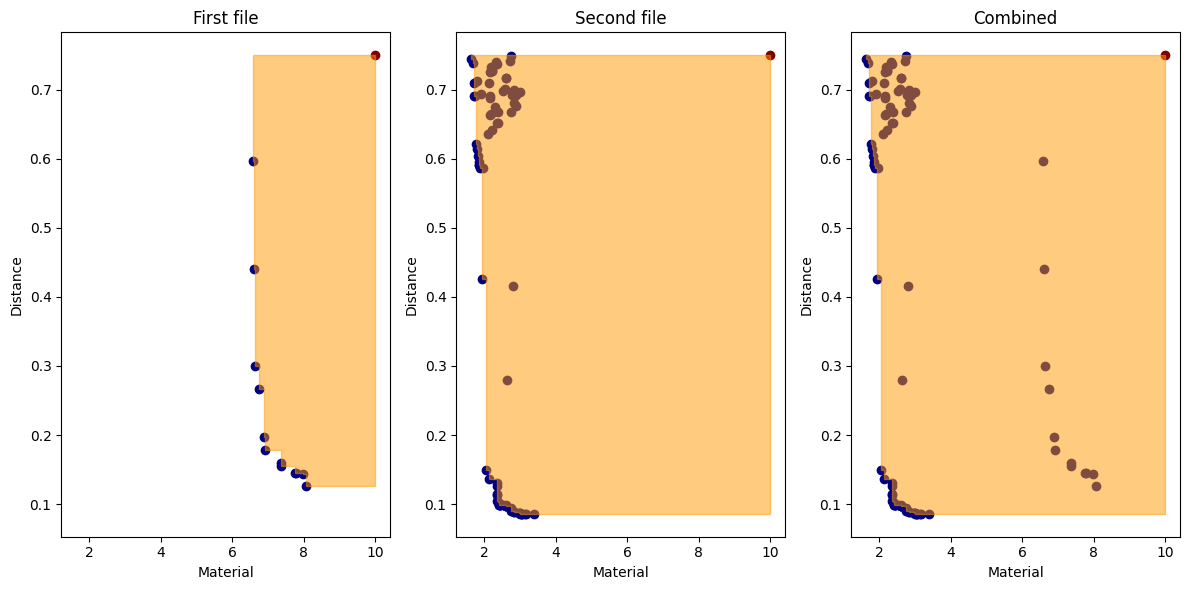

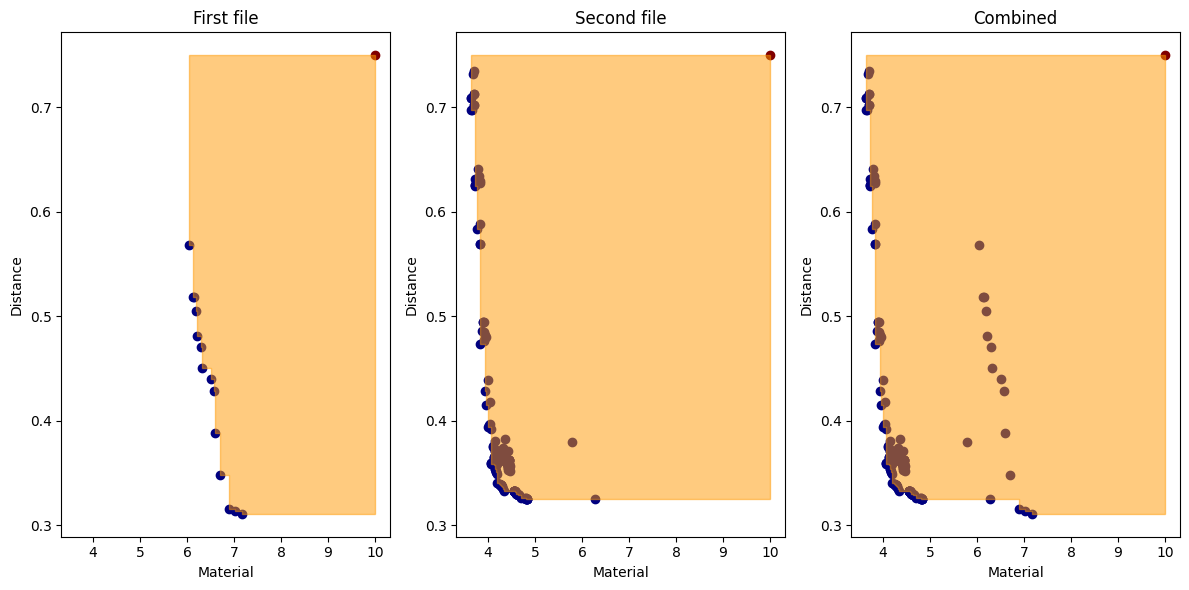

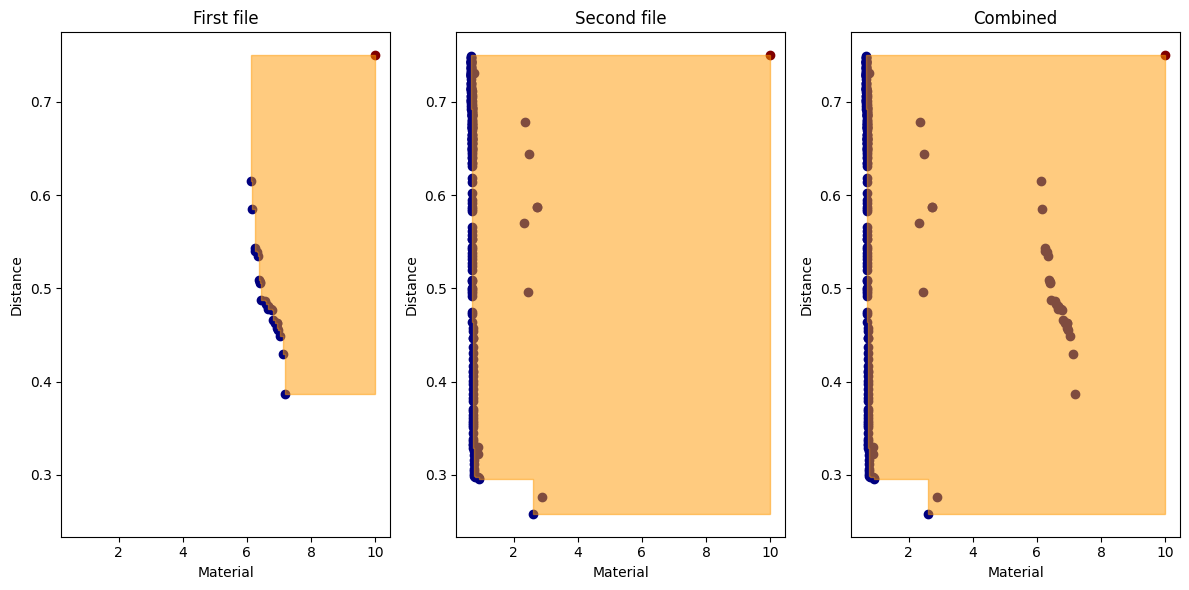

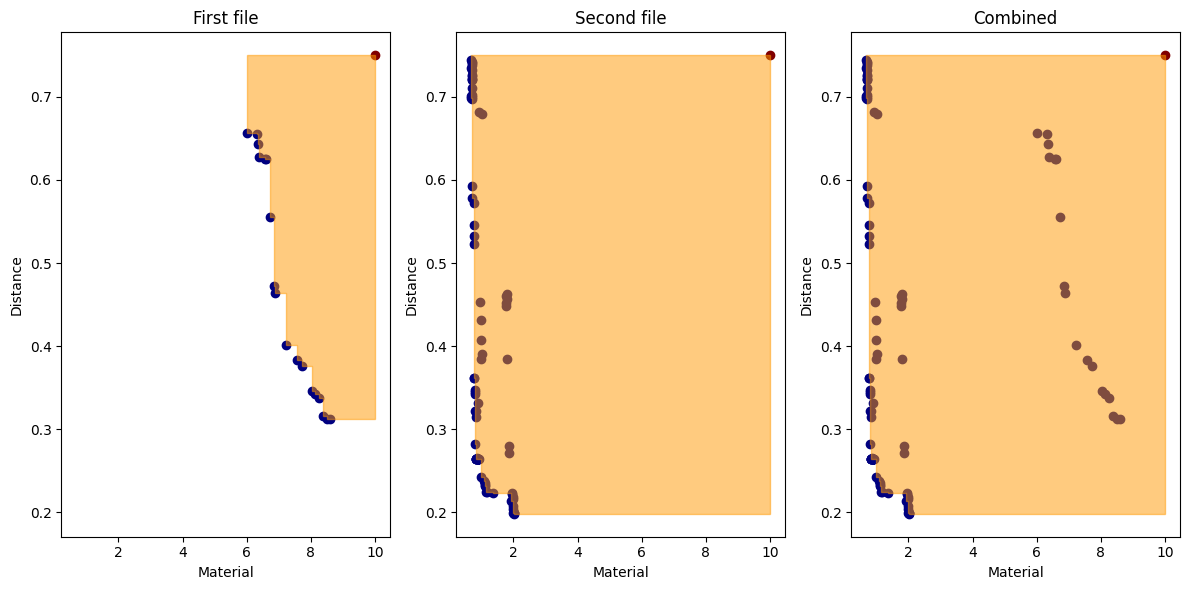

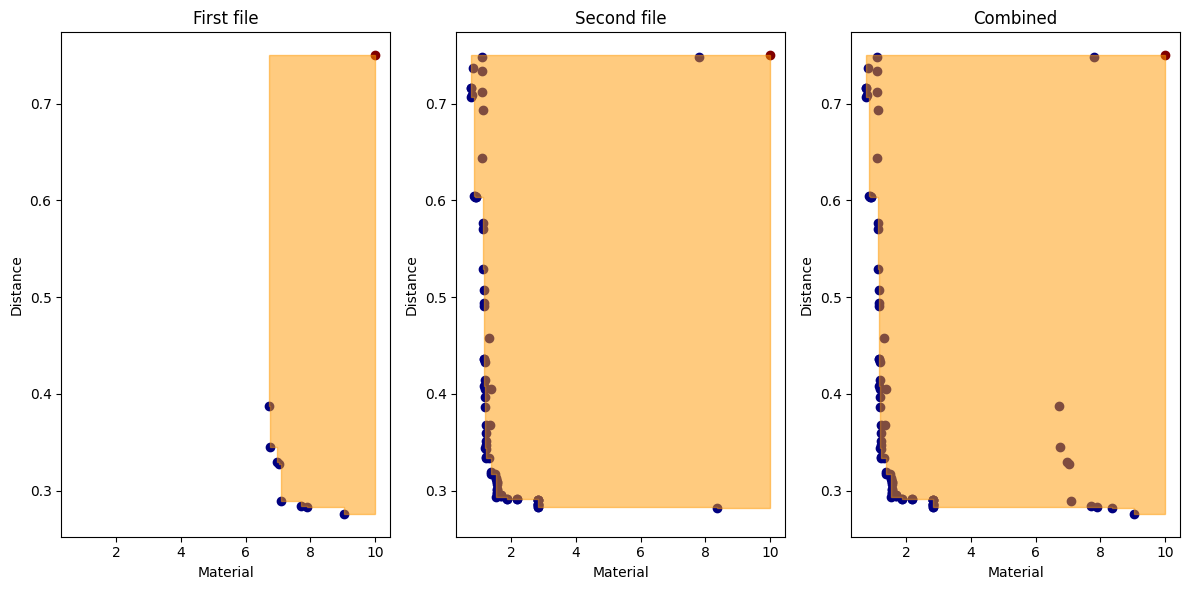

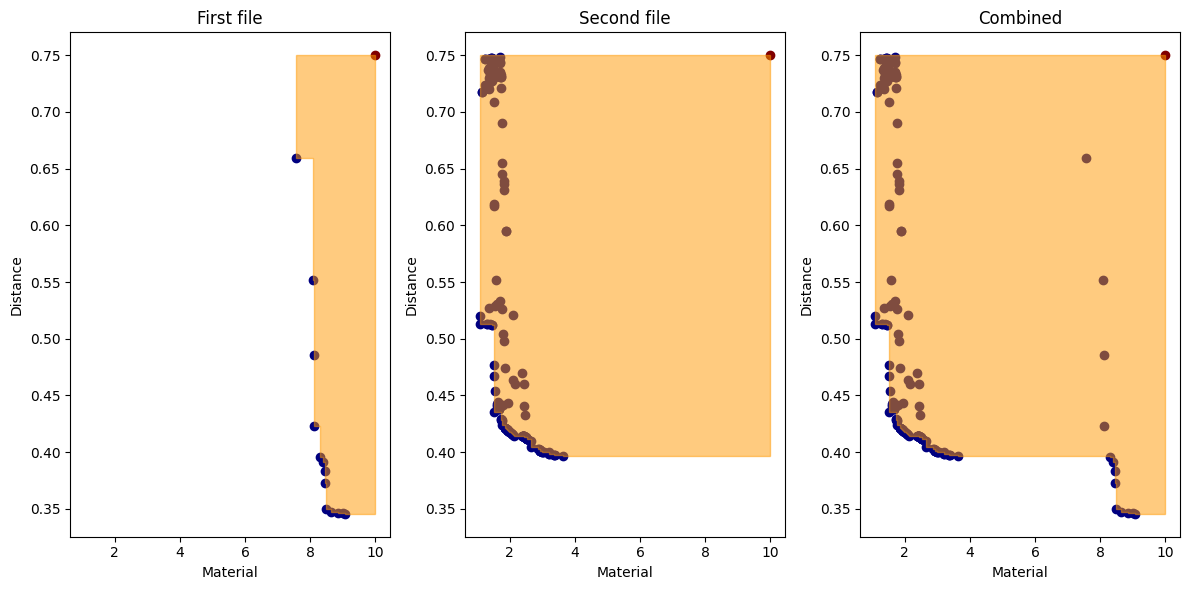

In [118]:
# Combine mechanism from 2 submission files
# file_path = f'my_full_submission_combined.npy'
file_path = "my_full_submission.npy"
# file_path2 = f'my_full_submission_GA_nodes_7_mech_1000_NUM_OF_GENERATIONS_1000.npy'
file_path2 = f'my_full_submission_GD_material_nodes_7_mech_100_STEP_SIZE_0.0004_NUM_OF_STEPS_1000.npy'
import numpy as np
from pprint import pprint

print('Loading:', file_path)
try:
    data = np.load(file_path, allow_pickle=True)
except Exception as e:
    raise RuntimeError(f'Failed to load {file_path}: {e}')
try:
    data2 = np.load(file_path2, allow_pickle=True)
except Exception as e:
    raise RuntimeError(f'Failed to load {file_path2}: {e}')

data.item()['Problem 1'] [0] 

for curve_index in curves:
    x01 = []
    edges1 = []
    fixed_joints1 = []
    motors1 = []
    x02 = []
    edges2 = []
    fixed_joints2 = []
    motors2 = []
    mechanisms = data.item()[f'Problem {curve_index +1}']
    mechanisms2 = data2.item()[f'Problem {curve_index +1}']


    for mech in mechanisms:
        x01.append(mech['x0'])
        edges1.append(mech['edges'])
        fixed_joints1.append(mech['fixed_joints'])
        motors1.append(mech['motor'])
    for mech in mechanisms2:
        x02.append(mech['x0'])
        edges2.append(mech['edges'])
        fixed_joints2.append(mech['fixed_joints'])
        motors2.append(mech['motor'])



    F_before = np.array(
        PROBLEM_TOOLS(
            x01,
            edges1,
            fixed_joints1,
            motors1,
            target_curves[curve_index],
        )).T
        
    F_after = np.array(
        PROBLEM_TOOLS(
            x02,
            edges2,
            fixed_joints2,
            motors2,
            target_curves[curve_index],
        )).T
    
    combined_x0s = x01 + x02
    combined_edges = edges1 + edges2
    combined_fixed_joints = fixed_joints1 + fixed_joints2
    combined_motors = motors1 + motors2

    F_combo = np.array(
        PROBLEM_TOOLS(
            combined_x0s,
            combined_edges,
            combined_fixed_joints,
            combined_motors,
            target_curves[curve_index],
        )).T
        
    ref = np.array([0.75, 10.0])
    ind = HV(ref)

    hv_before = ind(F_before)
    hv_after = ind(F_after)
    hv_combo = ind(F_combo)

    # VIZUALIZE
    print(f'Hypervolume first file: {hv_before:.4f}, second file:  {hv_after:.4f}, combined:  {hv_combo:.4f}')

    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    ax1 = axes[0]
    ax1.set_title('First file')
    ga_visualizer.plot_HV(F_before, ref, objective_labels=['Distance', 'Material'], ax=ax1)

    ax2 = axes[1]
    ax2.set_title('Second file')
    ga_visualizer.plot_HV(F_after, ref, objective_labels=['Distance', 'Material'], ax=ax2)

    ax3 = axes[2]
    ax3.set_title('Combined')
    ga_visualizer.plot_HV(F_combo, ref, objective_labels=['Distance', 'Material'], ax=ax3)


    # capture x/y limits from combined plot
    xlim = ax3.get_xlim()
    ylim = ax3.get_ylim()
    #and apply for the first
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)

    plt.tight_layout()

    # WRITE TO FILE
    mechanisms = []
    mech = {}
    for i in range(len(combined_x0s)):
        mech = {
                'x0': combined_x0s[i],
                'edges': combined_edges[i],
                'fixed_joints': combined_fixed_joints[i],
                'motor': combined_motors[i],
                #'target_joint': target_idx[i]
            }
        mechanisms.append(mech)

    file_name_temp = f'my_full_submission_combined'
    save_mechanisms(mechanisms, f'{file_name_temp}_curve_{curve_index}.npy', overwrite=True)
    print(file_name)

file_name = file_name_temp

In [119]:
def merge_submissions_best(sub_paths, output_path, num_per_curve=1000, target_curves_arg=None, problem_tools=None):
    """Merge multiple submission .npy files and keep up to `num_per_curve` best mechanisms per curve.

    Selection heuristic: sort by distance (ascending) then material (ascending).

    Parameters
    - sub_paths: list of paths to .npy submission files (each saved via `np.save(..., submission)`).
    - output_path: path to write merged submission .npy
    - num_per_curve: maximum mechanisms to keep per curve/problem
    - target_curves_arg: optional array of target curves; if None the function will try to use variable `target_curves` from the notebook globals.
    - problem_tools: optional PROBLEM_TOOLS-like callable; if None the function will try to use `PROBLEM_TOOLS` from globals.

    Returns the merged submission dict.
    """
    import numpy as np
    from LINKS.CP import make_empty_submission

    # resolve target curves and tools from globals if not provided
    if target_curves_arg is None:
        target_curves_arg = globals().get('target_curves')
        if target_curves_arg is None:
            raise RuntimeError('target_curves not provided and not found in globals')
    if problem_tools is None:
        problem_tools = globals().get('PROBLEM_TOOLS')
        if problem_tools is None:
            raise RuntimeError('PROBLEM_TOOLS not provided and not found in globals')

    # load submissions
    submissions = []
    for p in sub_paths:
        arr = np.load(p, allow_pickle=True)
        try:
            sub = arr.item()
        except Exception:
            # If saved as array-like of object, try to convert to dict
            sub = arr.tolist() if hasattr(arr, 'tolist') else dict(arr)
        submissions.append(sub)

    # collect all problem keys (e.g., 'Problem 1', ...)
    all_keys = []
    for sub in submissions:
        for k in sub.keys():
            if k not in all_keys:
                all_keys.append(k)

    merged = make_empty_submission()

    def mech_key(mech):
        # deterministic key for deduplication
        try:
            x0 = np.asarray(mech.get('x0'))
            edges = np.asarray(mech.get('edges'))
            fj = np.asarray(mech.get('fixed_joints'))
            motor = np.asarray(mech.get('motor')) if mech.get('motor') is not None else None
            return (tuple(np.round(x0.flatten(), 8).tolist()), tuple(map(tuple, edges.tolist())) , tuple(np.round(fj.flatten(), 8).tolist()), None if motor is None else tuple(np.round(motor.flatten(),8).tolist()))
        except Exception:
            return repr(mech)

    for key in sorted(all_keys):
        # parse curve index from key like 'Problem 1' -> index 0
        try:
            curve_idx = int(''.join([c for c in key if c.isdigit()])) - 1
        except Exception:
            # fallback - if we can't determine index, iterate sequentially
            curve_idx = 0

        # build combined list from all submissions for this key
        combined = []
        for sub in submissions:
            if key in sub:
                combined.extend(sub[key])

        # deduplicate
        unique = []
        seen = set()
        for mech in combined:
            k = mech_key(mech)
            if k in seen:
                continue
            seen.add(k)
            unique.append(mech)

        if len(unique) == 0:
            merged[key] = []
            continue

        # prepare arrays for evaluation
        x0s = []
        edges = []
        fixed_joints = []
        motors = []
        for mech in unique:
            x0s.append(mech.get('x0'))
            edges.append(mech.get('edges'))
            fixed_joints.append(mech.get('fixed_joints'))
            motors.append(mech.get('motor') if 'motor' in mech else mech.get('motors') if 'motors' in mech else None)

        # Evaluate using PROBLEM_TOOLS; handle single-item edge cases
        try:
            res = np.array(problem_tools(x0s, edges, fixed_joints, motors, target_curves_arg[curve_idx])).T
        except Exception:
            # Try alternative call signature without list-wrapping
            res = np.array(problem_tools(np.array(x0s), edges, fixed_joints, motors, target_curves_arg[curve_idx])).T

        if res.ndim == 1:
            res = res.reshape(1, -1)
        distances = res[:, 0]
        materials = res[:, 1]

        # sort by distance then material
        order = np.lexsort((materials, distances))

        top_idx = order[:min(num_per_curve, len(unique))]
        selected = [unique[i] for i in top_idx]

        merged[key] = selected

    # save merged submission
    np.save(output_path, merged)
    print(f"Saved merged submission to: {output_path}")
    # return merged dict
    return merged


# Example usage:
# merged = merge_submissions_best(['my_full_submission_fileA.npy', 'my_full_submission_fileB.npy'], 'my_merged_top1000.npy', num_per_curve=1000)
# print({k: len(v) for k, v in merged.items()})


In [121]:
import numpy as np
from pprint import pprint

# Load the mechanisms from the specified file
mechs = np.load('my_full_submission_combineded_curve_0.npy', allow_pickle=True)
print(f"Loaded {len(mechs)} mechanisms from my_full_submission_combineded_curve_0.npy")

# Show the first mechanism as an example
if len(mechs) > 0:
    pprint(mechs[0])
else:
    print("No mechanisms found in the file.")

FileNotFoundError: [Errno 2] No such file or directory: 'my_full_submission_combineded_curve_0.npy'